In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.metrics import mean_squared_error
from math import sqrt

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import TimeSeriesSplit

from sklearn import metrics
from sklearn.metrics import r2_score


from itertools import combinations

In [2]:


Company = pd.read_csv("Facebook.csv",index_col=0)
Google_trends_df = pd.read_csv("./New Data/Google_trends_data_updated.csv",index_col=0)
All = pd.read_csv("All.csv",index_col=0)

# Datetime for Apple
Company.date = pd.to_datetime(Company.date)
Company['Date_date']=Company['date'].apply(lambda x:x.date())
Company.Date_date = pd.to_datetime(Company.Date_date)
Company = Company.set_index('date')
All.index = pd.to_datetime(All.index)
# Adding Zika trends data
Company = pd.concat([Company, Google_trends_df['Covid-19'], Google_trends_df['zika']],axis=1)


Company = Company[503:-1] # from 2012-05-18 to 2020-04-29



Company['time'] = Company.index.to_series().apply(lambda x: x.toordinal())

Company = Company[['company_news','world_news','company_trends','Coronavirus', 'presidential election', 'Lockdown','Pandemic', 'Quarantine'

,'zika','Covid-19','time','Close']]

In [3]:
# slicing for time windows
Covid_19 = Company['2020-01-01':'2020-04-30']
Zika = Company['2015-01-01':'2016-01-01']
election_2016 = Company['2016-06-01':'2017-05-30']
election_2012 = Company['2012-06-01':'2013-05-30']

In [4]:
def MAPE(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
def predict(theta, X):
    return np.dot(X, theta)

def getThetaClosedForm(X,Y):
    theta = np.linalg.inv(X.T@X)@X.T@Y
    return theta

# Covid

In [5]:
df = Covid_19

In [6]:
df.index = pd.to_datetime(df.index)


In [7]:
#Standardize training
mean = np.mean(df, axis=0)
std = np.std(df, axis=0, ddof=1)
std_df = (df-mean)/std

In [8]:
cutIdx = int(len(std_df)*0.7)

In [9]:
X_train = std_df.drop('Close', axis=1)[:cutIdx]
y_train = std_df['Close'][:cutIdx]

# adding Bias
X_train = np.hstack([np.ones([X_train.shape[0],1]), X_train])

theta = getThetaClosedForm(X_train,y_train)
coefficient_df_scratch = pd.DataFrame(data = theta, index =["Bias_Constant",
                                                            'company_news', 'world_news', 'company_trends', 'Coronavirus',
                                                           'presidential election', 'Lockdown', 'Pandemic', 'Quarantine', 'zika',
                                                           'Covid-19', 'time'], columns = ["Coefficient"] )

# coefficient_df_scratch.sort_values(by=['Coefficient'], axis=0, ascending=False)

# coefficient_df_scratch.iloc[(coefficient_df_scratch['Coefficient'].abs()).argsort()]

print("Coefficients of the Covid_19 timewindow: ")
print(coefficient_df_scratch.iloc[(-coefficient_df_scratch['Coefficient'].abs()).argsort()])

Coefficients of the Covid_19 timewindow: 
                       Coefficient
Coronavirus              -0.646959
time                     -0.385745
Covid-19                 -0.229799
Quarantine                0.209661
Pandemic                  0.091969
Lockdown                 -0.077714
company_news              0.033853
world_news                0.028951
zika                     -0.019961
Bias_Constant            -0.017661
presidential election     0.015222
company_trends            0.002973


In [10]:
lists = list(std_df.columns)

lists.remove('Close') 

len_lists = len(lists)

target = ['Close']


In [11]:
# getting all combinations of features
lists_features = []
for i in range(len_lists):
    combs = list(combinations(lists,(i+1)))
#     print(combs)
    for k in combs:
        tuple_to_lists = list(k)
        tuple_to_lists.append('Close')
#         print(tuple_to_lists)
        lists_features.append(tuple_to_lists)

In [12]:
# getting PERFORMANCE_Scores of trainning for all combinations of features

features_PERFORMANCE_Scores = []
for features in lists_features:
    df_1 = std_df[features]
    X_train, X_test = df_1.drop('Close', axis=1)[:cutIdx], df_1.drop('Close', axis=1)[cutIdx:]
    y_train, y_test = df_1['Close'][:cutIdx], df_1['Close'][cutIdx:]
    
    # pandas dataframe to numpy array
    X_train = X_train.to_numpy()
    X_test = X_test.to_numpy()

    y_train = y_train.to_numpy()
    y_test = y_test.to_numpy()
    
    # adding Bias
    X_train = np.hstack([np.ones([X_train.shape[0],1]), X_train])
    X_test = np.hstack([np.ones([X_test.shape[0],1]), X_test])
    

    theta = getThetaClosedForm(X_train,y_train)
    
    Y_hat = predict(theta, X_train)

    # check perfromance score
    RMSE = sqrt(mean_squared_error(y_train, Y_hat))
#     print("mean_squared_error: ",RMSE)

    scores_lr = cross_val_score(LinearRegression(), 
                                X_train, y_train, 
                                cv=TimeSeriesSplit(n_splits=10),
                                scoring="neg_mean_squared_error")
    NMSE = np.mean(scores_lr)
#     print("neg_mean_squared_error: ",NMSE)
    MAPE_score = MAPE(y_train,Y_hat)
#     print("mean_absolute_percentage_error: ", MAPE_score )
    R2_score = r2_score(y_train,Y_hat)
#     print("R2 score: ", R2_score)
    features_PERFORMANCE_Scores.append([features,RMSE,NMSE,MAPE_score,R2_score])

In [13]:
# getting High_performence_features
selected_High_performence_features = []

for i in range(4):
    if i==3:
        features_PERFORMANCE_Scores.sort(key=lambda x: x[i+1],reverse=True)
    else:
        features_PERFORMANCE_Scores.sort(key=lambda x: x[i+1])
        
    selected_High_performence_features.append(features_PERFORMANCE_Scores[0])

In [14]:
Names = ['The Lowest root_mean_squared_error of the training set', 'The Lowest neg_mean_squared_error of the training set', 'The Lowest mean_absolute_percentage_error of the training set', 'The Highest R2_score of the training set']


selected_High_performence_features_names = []
for f,n in zip(selected_High_performence_features, Names):
    k = [f,n]
    selected_High_performence_features_names.append(k)

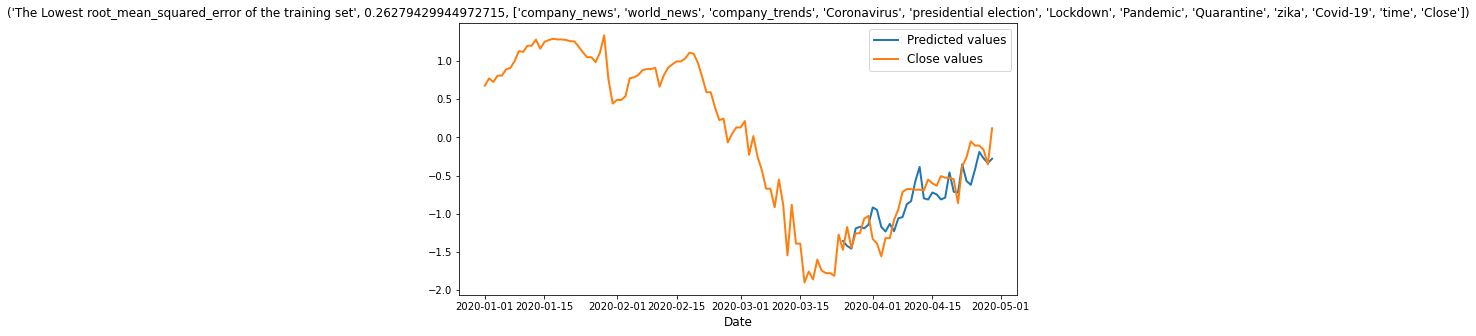

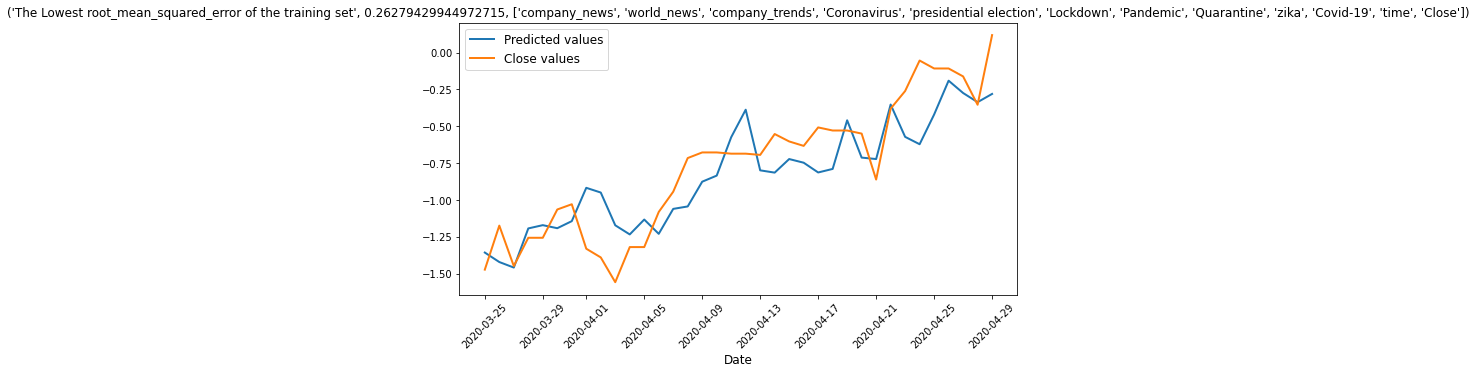

Root_mean_squared_error of the testing set:  0.23518442735279718
neg_mean_squared_error of the testing set:  -0.5134980372097255
mean_absolute_percentage_error of the testing set:  71.69624335337433
R2 score of the testing set:  0.7268048725512803


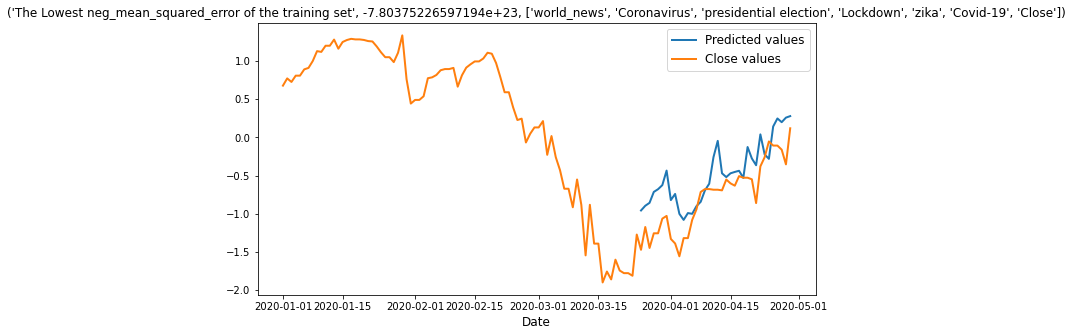

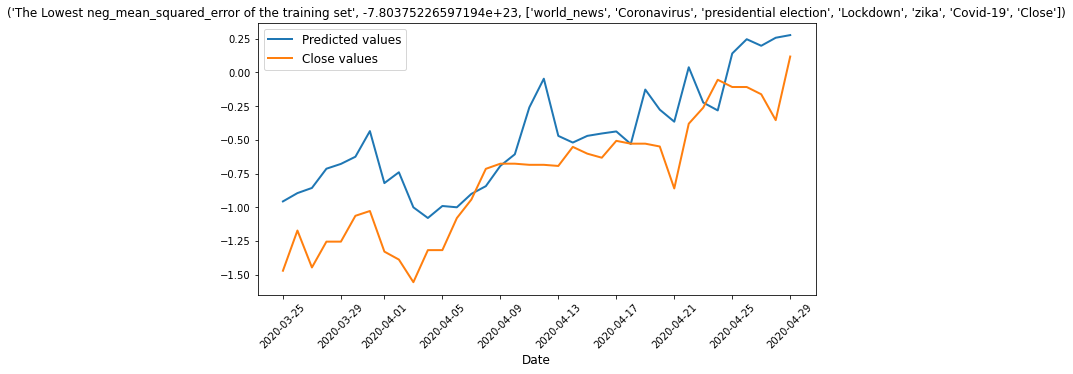

Root_mean_squared_error of the testing set:  0.3787005809137299
neg_mean_squared_error of the testing set:  -0.5969848888393728
mean_absolute_percentage_error of the testing set:  71.44072788449598
R2 score of the testing set:  0.29165021168405514


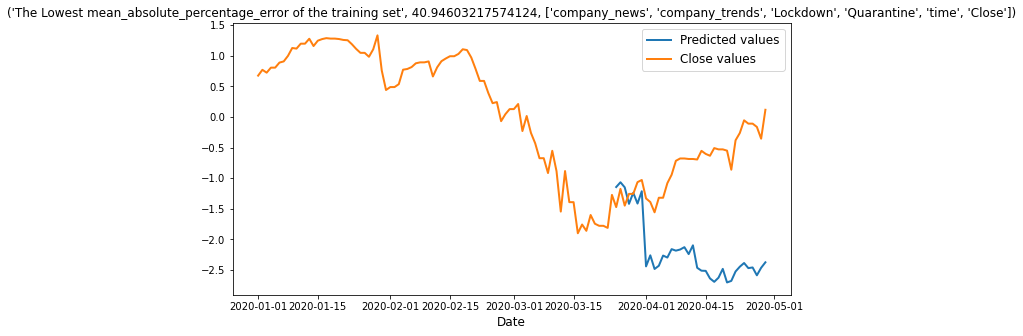

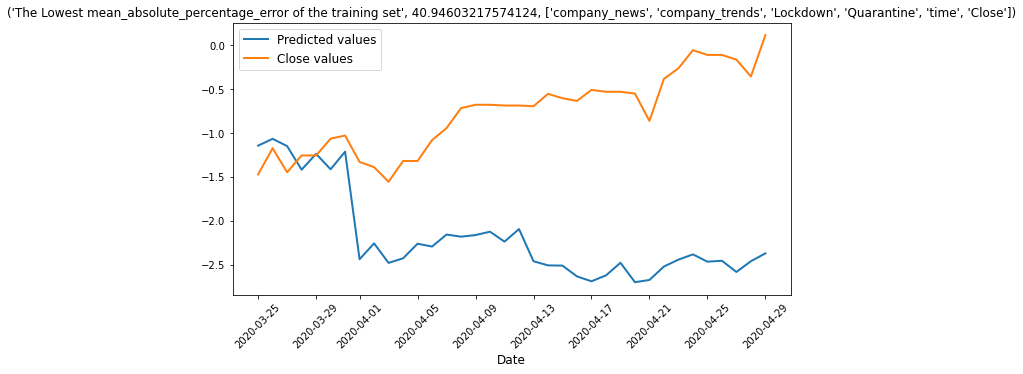

Root_mean_squared_error of the testing set:  1.6423059591393672
neg_mean_squared_error of the testing set:  -0.11813753933994234
mean_absolute_percentage_error of the testing set:  531.2545283492915
R2 score of the testing set:  -12.32183233037843


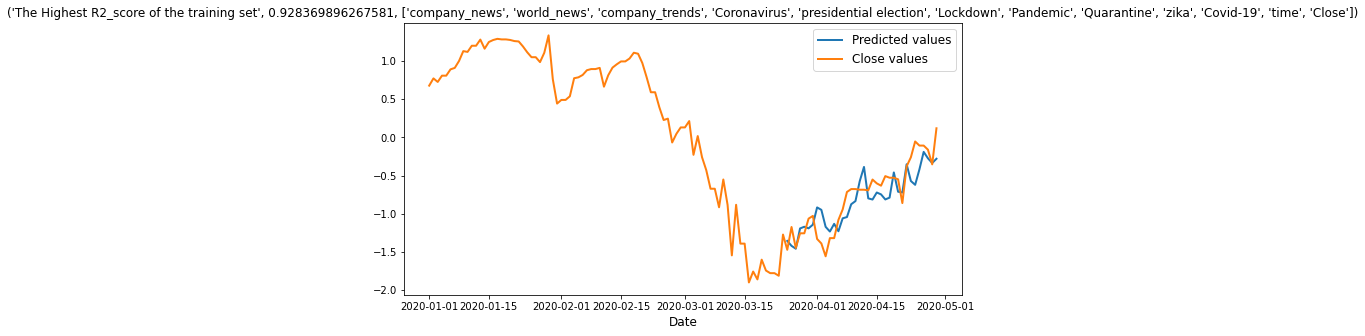

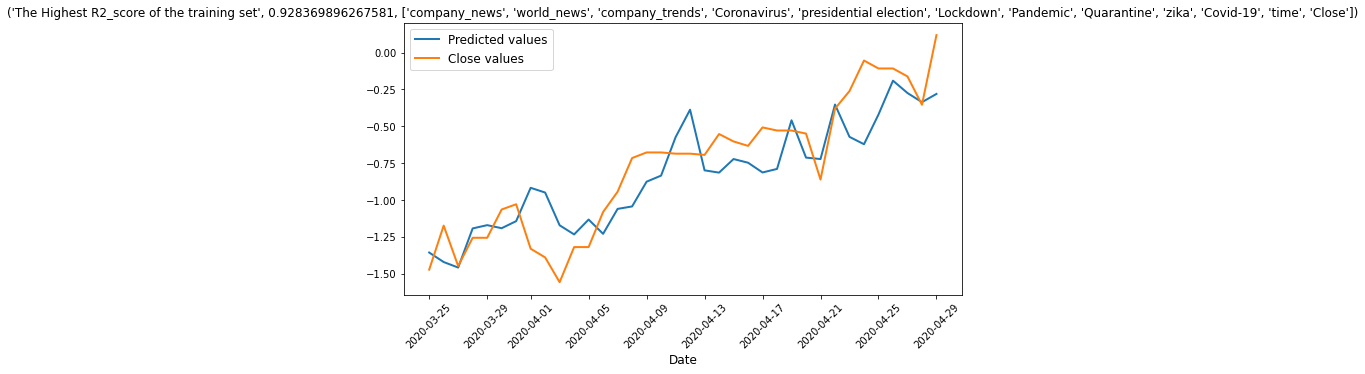

Root_mean_squared_error of the testing set:  0.23518442735279718
neg_mean_squared_error of the testing set:  -0.5134980372097255
mean_absolute_percentage_error of the testing set:  71.69624335337433
R2 score of the testing set:  0.7268048725512803


In [15]:
for k,i in enumerate(selected_High_performence_features_names):

    df_1 = std_df[i[0][0]]
    X_train, X_test = df_1.drop('Close', axis=1)[:cutIdx], df_1.drop('Close', axis=1)[cutIdx:]
    y_train, y_test = df_1['Close'][:cutIdx], df_1['Close'][cutIdx:]

    # pandas dataframe to numpy array
    X_train = X_train.to_numpy()
    X_test = X_test.to_numpy()

    y_train = y_train.to_numpy()
    y_test = y_test.to_numpy()

    # adding Bias
    X_train = np.hstack([np.ones([X_train.shape[0],1]), X_train])
    X_test = np.hstack([np.ones([X_test.shape[0],1]), X_test])


    theta = getThetaClosedForm(X_train,y_train)

    Y_hat = predict(theta, X_test)
    
    plt.figure(figsize=(10, 5))
    plt.plot(std_df[cutIdx:].index, Y_hat, label = 'Predicted values', linewidth=2)
    # plt.plot(std_df_1[['time']][cutIdx:].index, std_df_1[['Close']][cutIdx:], label = 'True vales', linewidth=2)
    plt.plot(std_df.index, std_df['Close'], label = 'Close values', linewidth=2)

    plt.legend(loc = 'best', fontsize = 12)
    plt.xlabel('Date', fontsize = 12)
    plt.title((i[-1],i[0][k+1],i[0][0]))
    plt.show()
    
    
    plt.figure(figsize=(10, 5))
    plt.plot(std_df[cutIdx:].index, Y_hat, label = 'Predicted values', linewidth=2)
    # plt.plot(std_df_1[['time']][cutIdx:].index, std_df_1[['Close']][cutIdx:], label = 'True vales', linewidth=2)
    plt.plot(std_df[cutIdx:].index, std_df['Close'][cutIdx:], label = 'Close values', linewidth=2)

    plt.legend(loc = 'best', fontsize = 12)
    plt.xlabel('Date', fontsize = 12)
    plt.title((i[-1],i[0][k+1],i[0][0]))
    plt.xticks(rotation=45)
    plt.show()
    
    # check perfromance score
    RMSE = sqrt(mean_squared_error(y_test, Y_hat))
    print("Root_mean_squared_error of the testing set: ",RMSE)

    scores_lr = cross_val_score(LinearRegression(), 
                                X_test, y_test, 
                                cv=TimeSeriesSplit(n_splits=10),
                                scoring="neg_mean_squared_error")
    NMSE = np.mean(scores_lr)
    print("neg_mean_squared_error of the testing set: ",NMSE)
    MAPE_score = MAPE(y_test,Y_hat)
    print("mean_absolute_percentage_error of the testing set: ", MAPE_score )
    R2_score = r2_score(y_test,Y_hat)
    print("R2 score of the testing set: ", R2_score)

In [1]:
print("The best performance features:", ['company_news', 'world_news', 'company_trends', 'Coronavirus', 'presidential election', 'Lockdown', 'Pandemic', 'Quarantine', 'zika', 'Covid-19', 'time', 'Close'])
print("Root_mean_squared_error:  0.23518442735279718")
print('neg_mean_squared_error:  -0.5134980372097255')
print('mean_absolute_percentage_error:  71.69624335337433')
print('R2 score:  0.7268048725512803')

# The best performance features: ['company_news', 'world_news', 'company_trends', 'Coronavirus', 'presidential election', 'Lockdown', 'Pandemic', 'Quarantine', 'zika', 'Covid-19', 'time', 'Close']
# Root_mean_squared_error:  0.23518442735279718
# neg_mean_squared_error:  -0.5134980372097255
# mean_absolute_percentage_error:  71.69624335337433
# R2 score:  0.7268048725512803

The best performance features: ['company_news', 'world_news', 'company_trends', 'Coronavirus', 'presidential election', 'Lockdown', 'Pandemic', 'Quarantine', 'zika', 'Covid-19', 'time', 'Close']
Root_mean_squared_error:  0.23518442735279718
neg_mean_squared_error:  -0.5134980372097255
mean_absolute_percentage_error:  71.69624335337433
R2 score:  0.7268048725512803


In [17]:
features_from_other_timewindows_based_on_Coefficients = [[['zika','Lockdown','presidential election','time','Close'],"Zika"],
                                                         [['Quarantine','presidential election','Lockdown','world_news','Close'],'Election 2012'],
                                                         [['time','zika','company_trends','Quarantine','Close'], 'Election 2016']]



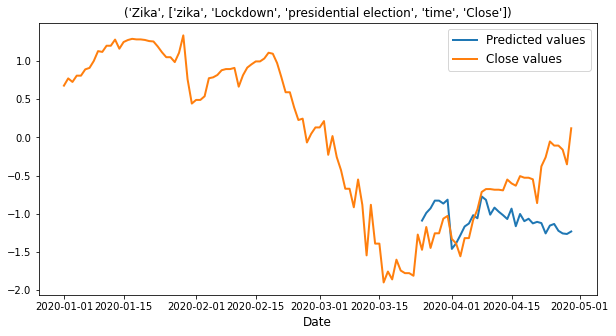

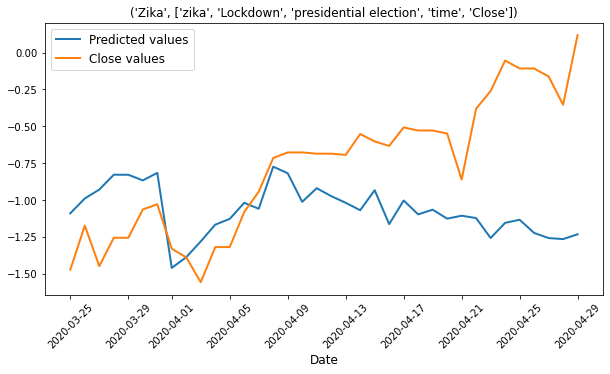

Root_mean_squared_error:  0.5833422132065269
neg_mean_squared_error:  -0.04792274828763952
mean_absolute_percentage_error:  216.89894118814982
R2 score:  -0.6807481266915796


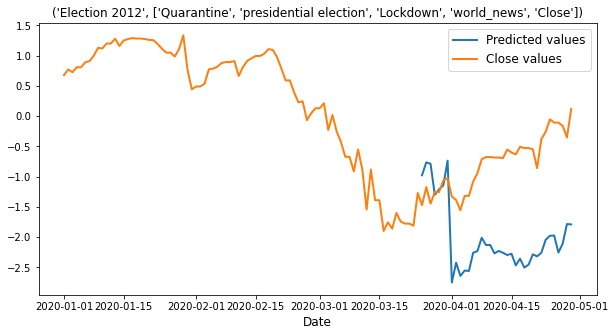

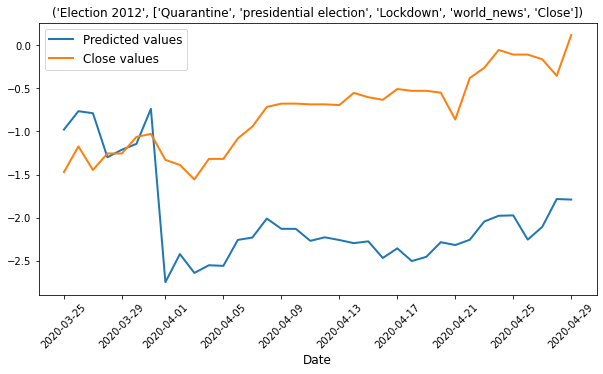

Root_mean_squared_error:  1.4710375240643383
neg_mean_squared_error:  -0.7894700220782224
mean_absolute_percentage_error:  452.66378496462715
R2 score:  -9.68816938960734


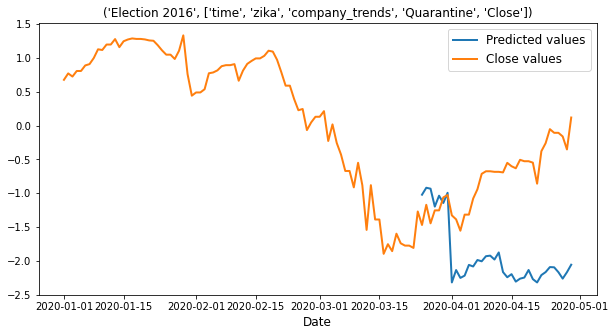

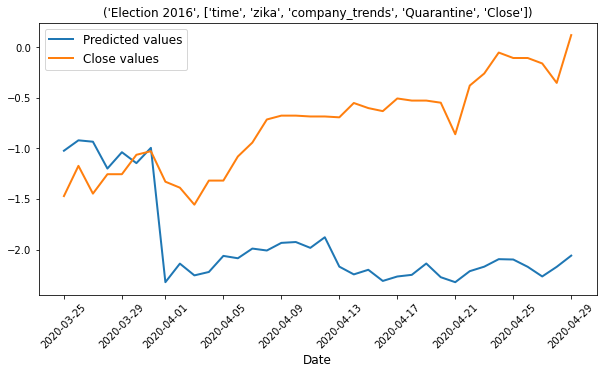

Root_mean_squared_error:  1.394341703176114
neg_mean_squared_error:  -2.6408156622332575
mean_absolute_percentage_error:  457.1540526218085
R2 score:  -8.602719861730996


In [18]:
for k,i in enumerate(features_from_other_timewindows_based_on_Coefficients):

    df_1 = std_df[i[0]]
    X_train, X_test = df_1.drop('Close', axis=1)[:cutIdx], df_1.drop('Close', axis=1)[cutIdx:]
    y_train, y_test = df_1['Close'][:cutIdx], df_1['Close'][cutIdx:]

    # pandas dataframe to numpy array
    X_train = X_train.to_numpy()
    X_test = X_test.to_numpy()

    y_train = y_train.to_numpy()
    y_test = y_test.to_numpy()

    # adding Bias
    X_train = np.hstack([np.ones([X_train.shape[0],1]), X_train])
    X_test = np.hstack([np.ones([X_test.shape[0],1]), X_test])


    theta = getThetaClosedForm(X_train,y_train)

    Y_hat = predict(theta, X_test)
    
    plt.figure(figsize=(10, 5))
    plt.plot(std_df[cutIdx:].index, Y_hat, label = 'Predicted values', linewidth=2)
    # plt.plot(std_df_1[['time']][cutIdx:].index, std_df_1[['Close']][cutIdx:], label = 'True vales', linewidth=2)
    plt.plot(std_df.index, std_df['Close'], label = 'Close values', linewidth=2)

    plt.legend(loc = 'best', fontsize = 12)
    plt.xlabel('Date', fontsize = 12)
    plt.title((i[-1],i[0]))
    plt.show()
    
    
    plt.figure(figsize=(10, 5))
    plt.plot(std_df[cutIdx:].index, Y_hat, label = 'Predicted values', linewidth=2)
    # plt.plot(std_df_1[['time']][cutIdx:].index, std_df_1[['Close']][cutIdx:], label = 'True vales', linewidth=2)
    plt.plot(std_df[cutIdx:].index, std_df['Close'][cutIdx:], label = 'Close values', linewidth=2)

    plt.legend(loc = 'best', fontsize = 12)
    plt.xlabel('Date', fontsize = 12)
    plt.title((i[-1],i[0]))
    plt.xticks(rotation=45)
    plt.show()
    
        # check perfromance score
    RMSE = sqrt(mean_squared_error(y_test, Y_hat))
    print("Root_mean_squared_error: ",RMSE)

    scores_lr = cross_val_score(LinearRegression(), 
                                X_test, y_test, 
                                cv=TimeSeriesSplit(n_splits=10),
                                scoring="neg_mean_squared_error")
    NMSE = np.mean(scores_lr)
    print("neg_mean_squared_error: ",NMSE)
    MAPE_score = MAPE(y_test,Y_hat)
    print("mean_absolute_percentage_error: ", MAPE_score )
    R2_score = r2_score(y_test,Y_hat)
    print("R2 score: ", R2_score)

# Zika

In [19]:
# removing covid_19, coronavirus features which have only 0s.
df = Zika[['company_news', 'world_news', 'company_trends',
       'presidential election', 'Lockdown', 'Pandemic', 'Quarantine', 'zika',
        'time', 'Close']]

In [20]:
df.index = pd.to_datetime(df.index)


In [21]:
#Standardize training
mean = np.mean(df, axis=0)
std = np.std(df, axis=0, ddof=1)
std_df = (df-mean)/std

In [22]:
cutIdx = int(len(std_df)*0.7)

In [23]:
X_train = std_df.drop('Close', axis=1)[:cutIdx]
y_train = std_df['Close'][:cutIdx]

# adding Bias
X_train = np.hstack([np.ones([X_train.shape[0],1]), X_train])

theta = getThetaClosedForm(X_train,y_train)
coefficient_df_scratch = pd.DataFrame(data = theta, index =["Bias_Constant",
                                                            'company_news', 'world_news', 'company_trends',
       'presidential election', 'Lockdown', 'Pandemic', 'Quarantine', 'zika',
        'time'], columns = ["Coefficient"] )

# coefficient_df_scratch.sort_values(by=['Coefficient'], axis=0, ascending=False)

# coefficient_df_scratch.iloc[(coefficient_df_scratch['Coefficient'].abs()).argsort()]

print("Coefficients of the Zika timewindow: ")
print(coefficient_df_scratch.iloc[(-coefficient_df_scratch['Coefficient'].abs()).argsort()])

Coefficients of the Zika timewindow: 
                       Coefficient
time                      0.634501
zika                      0.479122
presidential election     0.123937
Bias_Constant            -0.084628
Lockdown                 -0.069454
Quarantine                0.033054
Pandemic                 -0.022607
company_trends            0.015214
company_news              0.014126
world_news                0.011143


In [24]:
lists = list(std_df.columns)

lists.remove('Close') 

len_lists = len(lists)

target = ['Close']


In [25]:
# getting all combinations of features
lists_features = []
for i in range(len_lists):
    combs = list(combinations(lists,(i+1)))
#     print(combs)
    for k in combs:
        tuple_to_lists = list(k)
        tuple_to_lists.append('Close')
#         print(tuple_to_lists)
        lists_features.append(tuple_to_lists)

In [26]:
# getting PERFORMANCE_Scores of trainning for all combinations of features

features_PERFORMANCE_Scores = []
for features in lists_features:
    df_1 = std_df[features]
    X_train, X_test = df_1.drop('Close', axis=1)[:cutIdx], df_1.drop('Close', axis=1)[cutIdx:]
    y_train, y_test = df_1['Close'][:cutIdx], df_1['Close'][cutIdx:]
    
    # pandas dataframe to numpy array
    X_train = X_train.to_numpy()
    X_test = X_test.to_numpy()

    y_train = y_train.to_numpy()
    y_test = y_test.to_numpy()
    
    # adding Bias
    X_train = np.hstack([np.ones([X_train.shape[0],1]), X_train])
    X_test = np.hstack([np.ones([X_test.shape[0],1]), X_test])
    

    theta = getThetaClosedForm(X_train,y_train)
    
    Y_hat = predict(theta, X_train)

    # check perfromance score
    RMSE = sqrt(mean_squared_error(y_train, Y_hat))
#     print("mean_squared_error: ",RMSE)

    scores_lr = cross_val_score(LinearRegression(), 
                                X_train, y_train, 
                                cv=TimeSeriesSplit(n_splits=10),
                                scoring="neg_mean_squared_error")
    NMSE = np.mean(scores_lr)
#     print("neg_mean_squared_error: ",NMSE)
    MAPE_score = MAPE(y_train,Y_hat)
#     print("mean_absolute_percentage_error: ", MAPE_score )
    R2_score = r2_score(y_train,Y_hat)
#     print("R2 score: ", R2_score)
    features_PERFORMANCE_Scores.append([features,RMSE,NMSE,MAPE_score,R2_score])

In [27]:
# getting High_performence_features
selected_High_performence_features = []

for i in range(4):
    if i==3:
        features_PERFORMANCE_Scores.sort(key=lambda x: x[i+1],reverse=True)
    else:
        features_PERFORMANCE_Scores.sort(key=lambda x: x[i+1])
        
    selected_High_performence_features.append(features_PERFORMANCE_Scores[0])

In [28]:
# Names = ['The Lowest root_mean_squared_error', 'The Lowest neg_mean_squared_error', 'The Lowest mean_absolute_percentage_error', 'The Highest R2_score']

selected_High_performence_features_names = []
for f,n in zip(selected_High_performence_features, Names):
    k = [f,n]
    selected_High_performence_features_names.append(k)

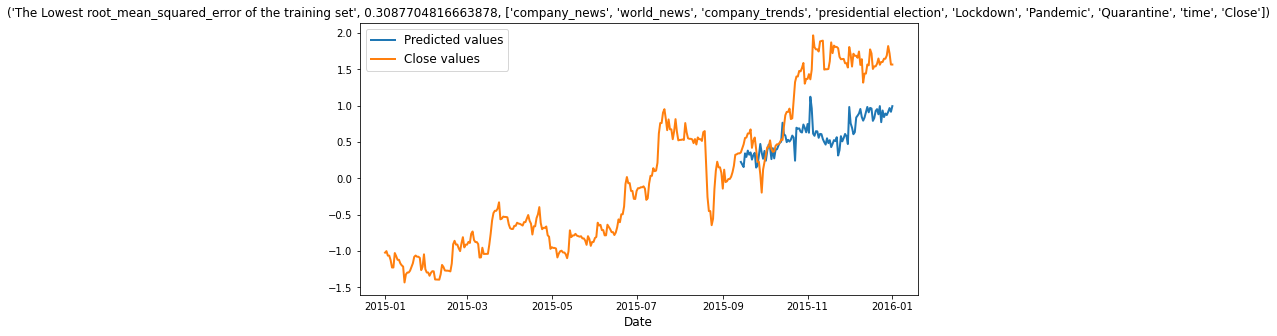

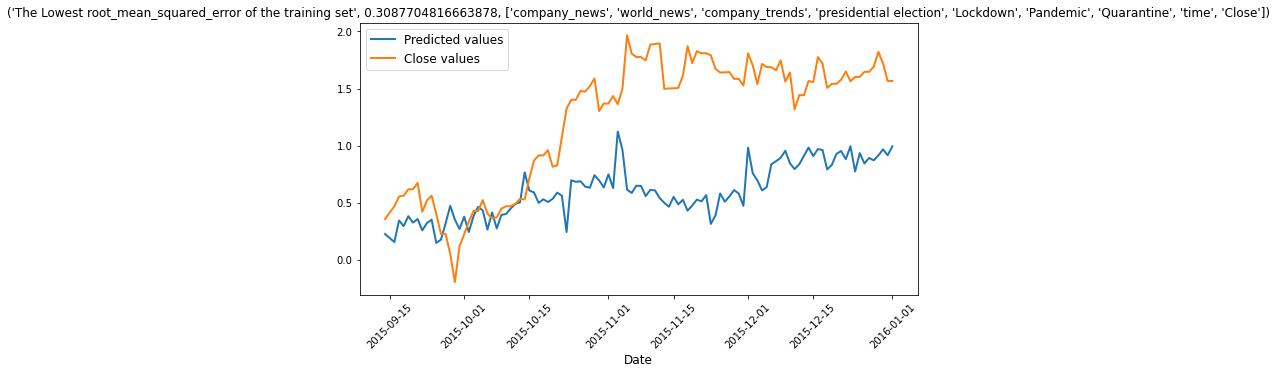

Root_mean_squared_error of the testing set:  0.7670684425624372
neg_mean_squared_error of the testing set:  -0.25952133835027447
mean_absolute_percentage_error of the testing set:  57.338059527581386
R2 score of the testing set:  -0.8318857683203043


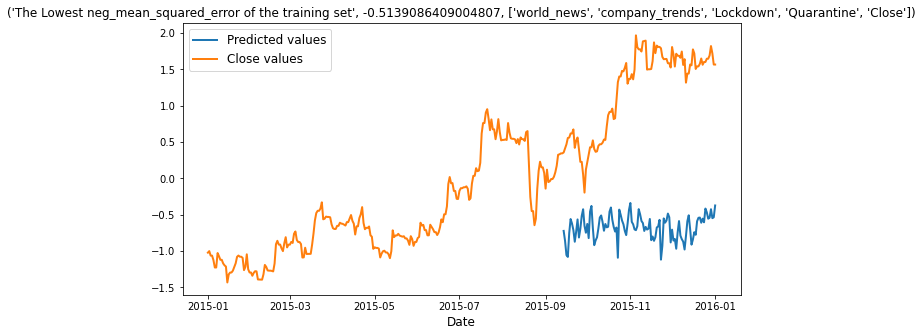

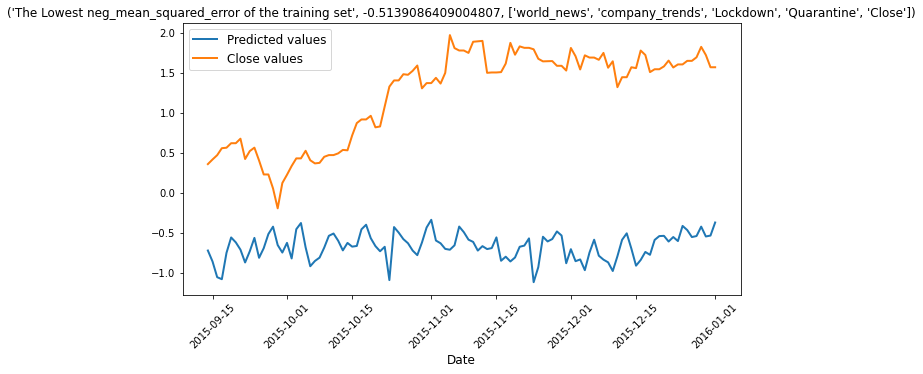

Root_mean_squared_error of the testing set:  1.9806727148763232
neg_mean_squared_error of the testing set:  -0.4609116026076948
mean_absolute_percentage_error of the testing set:  188.87002015060924
R2 score of the testing set:  -11.213934715409856


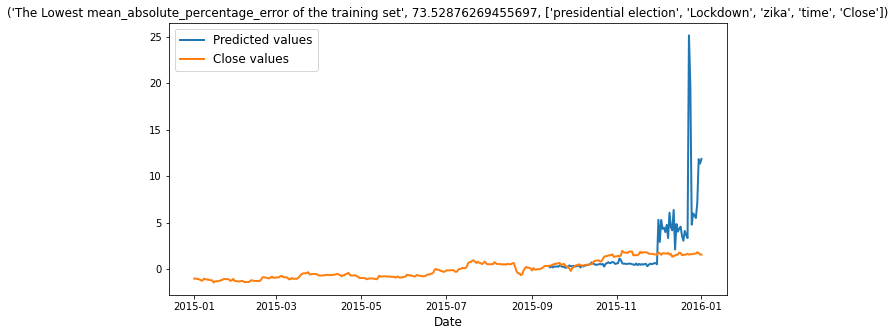

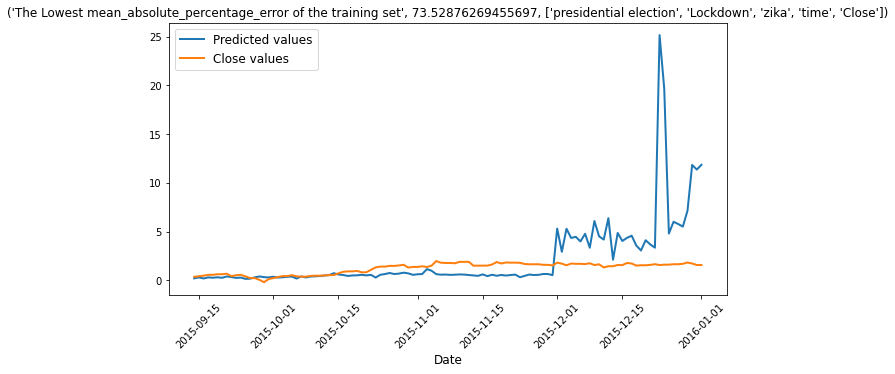

Root_mean_squared_error of the testing set:  3.6879299199881475
neg_mean_squared_error of the testing set:  -1.7407361344498e+23
mean_absolute_percentage_error of the testing set:  128.32766030047443
R2 score of the testing set:  -41.344350519572224


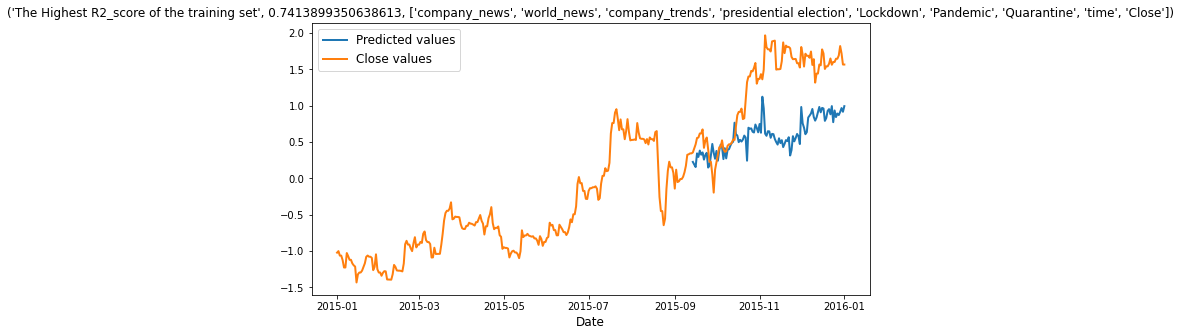

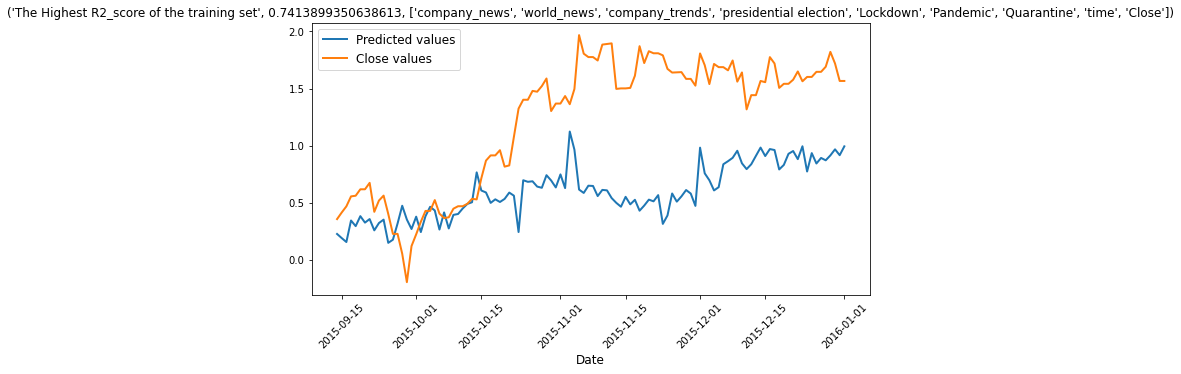

Root_mean_squared_error of the testing set:  0.7670684425624372
neg_mean_squared_error of the testing set:  -0.25952133835027447
mean_absolute_percentage_error of the testing set:  57.338059527581386
R2 score of the testing set:  -0.8318857683203043


In [29]:
for k,i in enumerate(selected_High_performence_features_names):

    df_1 = std_df[i[0][0]]
    X_train, X_test = df_1.drop('Close', axis=1)[:cutIdx], df_1.drop('Close', axis=1)[cutIdx:]
    y_train, y_test = df_1['Close'][:cutIdx], df_1['Close'][cutIdx:]

    # pandas dataframe to numpy array
    X_train = X_train.to_numpy()
    X_test = X_test.to_numpy()

    y_train = y_train.to_numpy()
    y_test = y_test.to_numpy()

    # adding Bias
    X_train = np.hstack([np.ones([X_train.shape[0],1]), X_train])
    X_test = np.hstack([np.ones([X_test.shape[0],1]), X_test])


    theta = getThetaClosedForm(X_train,y_train)

    Y_hat = predict(theta, X_test)
    
    plt.figure(figsize=(10, 5))
    plt.plot(std_df[cutIdx:].index, Y_hat, label = 'Predicted values', linewidth=2)
    # plt.plot(std_df_1[['time']][cutIdx:].index, std_df_1[['Close']][cutIdx:], label = 'True vales', linewidth=2)
    plt.plot(std_df.index, std_df['Close'], label = 'Close values', linewidth=2)

    plt.legend(loc = 'best', fontsize = 12)
    plt.xlabel('Date', fontsize = 12)
    plt.title((i[-1],i[0][k+1],i[0][0]))
    plt.show()
    
    
    plt.figure(figsize=(10, 5))
    plt.plot(std_df[cutIdx:].index, Y_hat, label = 'Predicted values', linewidth=2)
    # plt.plot(std_df_1[['time']][cutIdx:].index, std_df_1[['Close']][cutIdx:], label = 'True vales', linewidth=2)
    plt.plot(std_df[cutIdx:].index, std_df['Close'][cutIdx:], label = 'Close values', linewidth=2)

    plt.legend(loc = 'best', fontsize = 12)
    plt.xlabel('Date', fontsize = 12)
    plt.title((i[-1],i[0][k+1],i[0][0]))
    plt.xticks(rotation=45)
    plt.show()
    
    # check perfromance score
    RMSE = sqrt(mean_squared_error(y_test, Y_hat))
    print("Root_mean_squared_error of the testing set: ",RMSE)

    scores_lr = cross_val_score(LinearRegression(), 
                                X_test, y_test, 
                                cv=TimeSeriesSplit(n_splits=10),
                                scoring="neg_mean_squared_error")
    NMSE = np.mean(scores_lr)
    print("neg_mean_squared_error of the testing set: ",NMSE)
    MAPE_score = MAPE(y_test,Y_hat)
    print("mean_absolute_percentage_error of the testing set: ", MAPE_score )
    R2_score = r2_score(y_test,Y_hat)
    print("R2 score of the testing set: ", R2_score)

# Election 2012

In [30]:
# removing covid_19, coronavirus, zika features which have only 0s.
df = election_2012[['company_news', 'world_news', 'company_trends', 
       'presidential election', 'Lockdown', 'Pandemic', 'Quarantine', 
        'time', 'Close']]

In [31]:
df.index = pd.to_datetime(df.index)


In [32]:
#Standardize training
mean = np.mean(df, axis=0)
std = np.std(df, axis=0, ddof=1)
std_df = (df-mean)/std

In [33]:
cutIdx = int(len(std_df)*0.7)

In [34]:
X_train = std_df.drop('Close', axis=1)[:cutIdx]
y_train = std_df['Close'][:cutIdx]

# adding Bias
X_train = np.hstack([np.ones([X_train.shape[0],1]), X_train])

theta = getThetaClosedForm(X_train,y_train)
coefficient_df_scratch = pd.DataFrame(data = theta, index =["Bias_Constant",
                                                            'company_news', 'world_news', 'company_trends', 
       'presidential election', 'Lockdown', 'Pandemic', 'Quarantine', 
        'time'], columns = ["Coefficient"] )

# coefficient_df_scratch.sort_values(by=['Coefficient'], axis=0, ascending=False)

# coefficient_df_scratch.iloc[(coefficient_df_scratch['Coefficient'].abs()).argsort()]

print("Coefficients of the Election 2012 timewindow: ")
print(coefficient_df_scratch.iloc[(-coefficient_df_scratch['Coefficient'].abs()).argsort()])

Coefficients of the Election 2012 timewindow: 
                       Coefficient
presidential election    -0.363710
Lockdown                  0.278539
Quarantine               -0.132358
world_news                0.108743
time                      0.103873
company_news              0.070765
Bias_Constant            -0.021856
company_trends            0.015400
Pandemic                  0.005390


In [35]:
lists = list(std_df.columns)

lists.remove('Close') 

len_lists = len(lists)

target = ['Close']


In [36]:
# getting all combinations of features
lists_features = []
for i in range(len_lists):
    combs = list(combinations(lists,(i+1)))
#     print(combs)
    for k in combs:
        tuple_to_lists = list(k)
        tuple_to_lists.append('Close')
#         print(tuple_to_lists)
        lists_features.append(tuple_to_lists)

In [37]:
# getting PERFORMANCE_Scores of trainning for all combinations of features

features_PERFORMANCE_Scores = []
for features in lists_features:
    df_1 = std_df[features]
    X_train, X_test = df_1.drop('Close', axis=1)[:cutIdx], df_1.drop('Close', axis=1)[cutIdx:]
    y_train, y_test = df_1['Close'][:cutIdx], df_1['Close'][cutIdx:]
    
    # pandas dataframe to numpy array
    X_train = X_train.to_numpy()
    X_test = X_test.to_numpy()

    y_train = y_train.to_numpy()
    y_test = y_test.to_numpy()
    
    # adding Bias
    X_train = np.hstack([np.ones([X_train.shape[0],1]), X_train])
    X_test = np.hstack([np.ones([X_test.shape[0],1]), X_test])
    

    theta = getThetaClosedForm(X_train,y_train)
    
    Y_hat = predict(theta, X_train)

    # check perfromance score
    RMSE = sqrt(mean_squared_error(y_train, Y_hat))
#     print("mean_squared_error: ",RMSE)

    scores_lr = cross_val_score(LinearRegression(), 
                                X_train, y_train, 
                                cv=TimeSeriesSplit(n_splits=10),
                                scoring="neg_mean_squared_error")
    NMSE = np.mean(scores_lr)
#     print("neg_mean_squared_error: ",NMSE)
    MAPE_score = MAPE(y_train,Y_hat)
#     print("mean_absolute_percentage_error: ", MAPE_score )
    R2_score = r2_score(y_train,Y_hat)
#     print("R2 score: ", R2_score)
    features_PERFORMANCE_Scores.append([features,RMSE,NMSE,MAPE_score,R2_score])

In [38]:
# getting High_performence_features
selected_High_performence_features = []

for i in range(4):
    if i==3:
        features_PERFORMANCE_Scores.sort(key=lambda x: x[i+1],reverse=True)
    else:
        features_PERFORMANCE_Scores.sort(key=lambda x: x[i+1])
        
    selected_High_performence_features.append(features_PERFORMANCE_Scores[0])

In [39]:
# Names = ['The Lowest root_mean_squared_error', 'The Lowest neg_mean_squared_error', 'The Lowest mean_absolute_percentage_error', 'The Highest R2_score']

selected_High_performence_features_names = []
for f,n in zip(selected_High_performence_features, Names):
    k = [f,n]
    selected_High_performence_features_names.append(k)

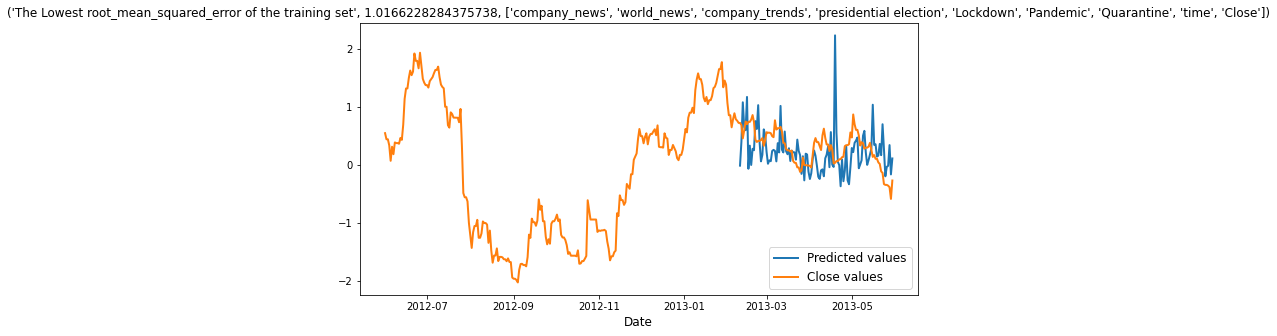

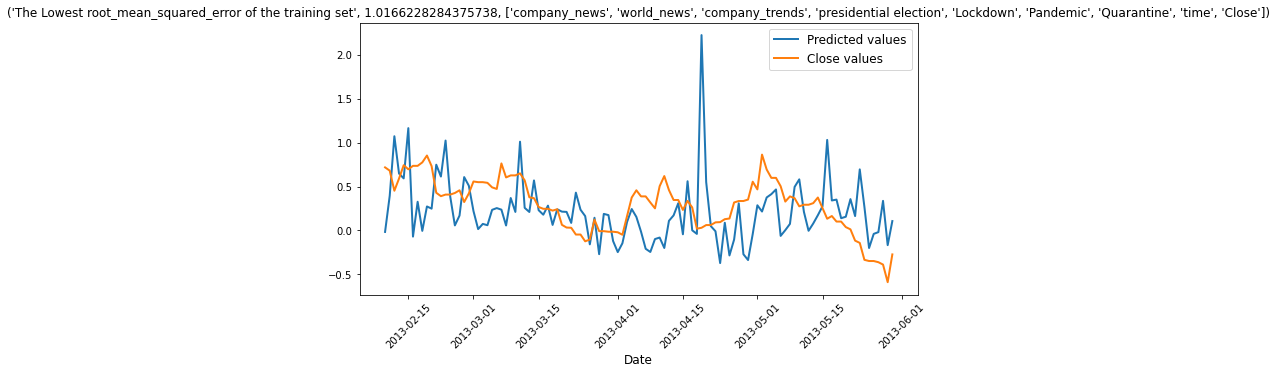

Root_mean_squared_error of the testing set:  0.43592699093010784
neg_mean_squared_error of the testing set:  -0.11415742547917358
mean_absolute_percentage_error of the testing set:  289.7360788045864
R2 score of the testing set:  -1.1161020228355523


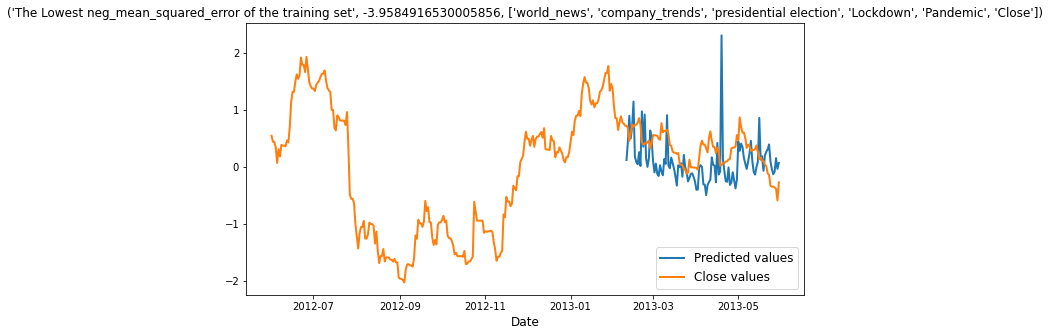

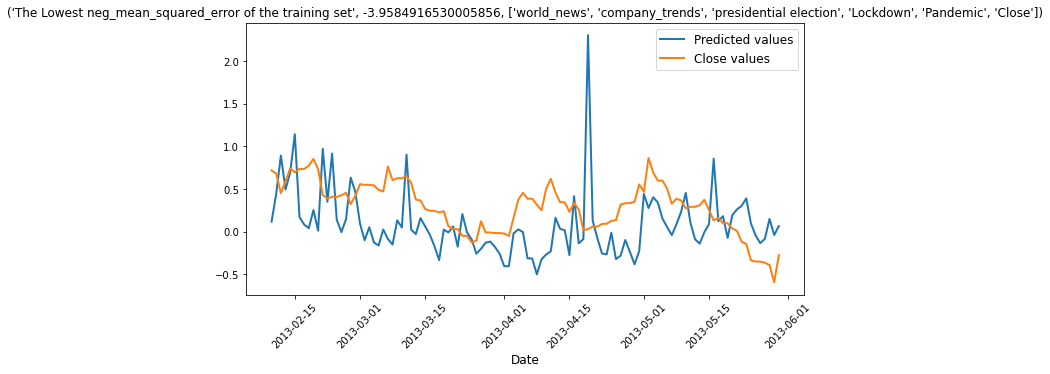

Root_mean_squared_error of the testing set:  0.48315317158597015
neg_mean_squared_error of the testing set:  -0.12060867190284727
mean_absolute_percentage_error of the testing set:  287.03837178494456
R2 score of the testing set:  -1.5994337445537896


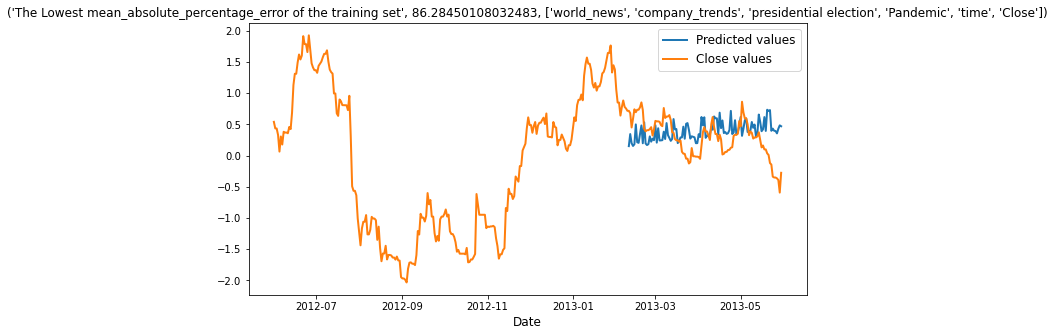

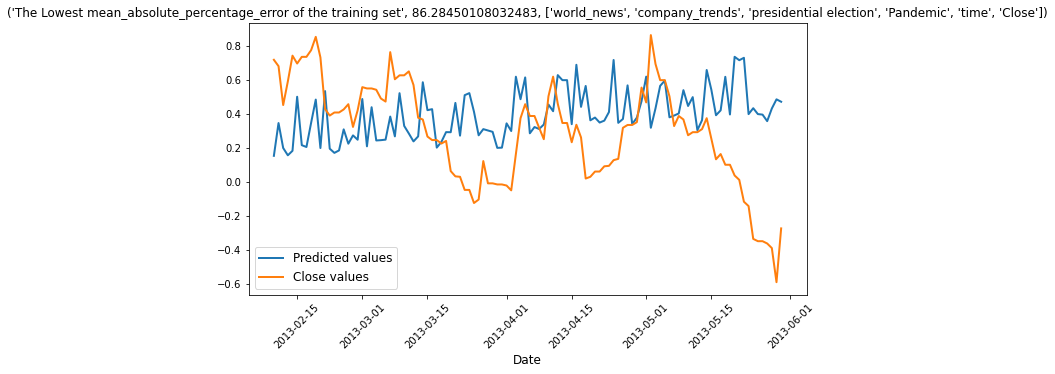

Root_mean_squared_error of the testing set:  0.3703591475411198
neg_mean_squared_error of the testing set:  -0.10953750101402007
mean_absolute_percentage_error of the testing set:  354.9694176015908
R2 score of the testing set:  -0.5274086105819313


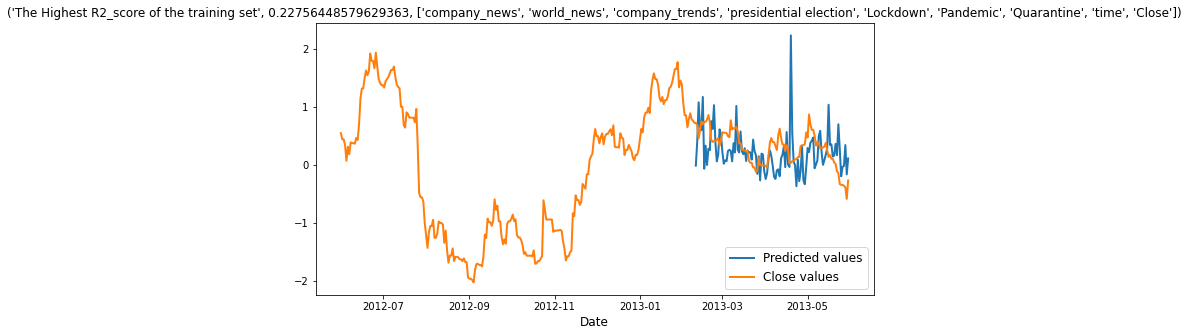

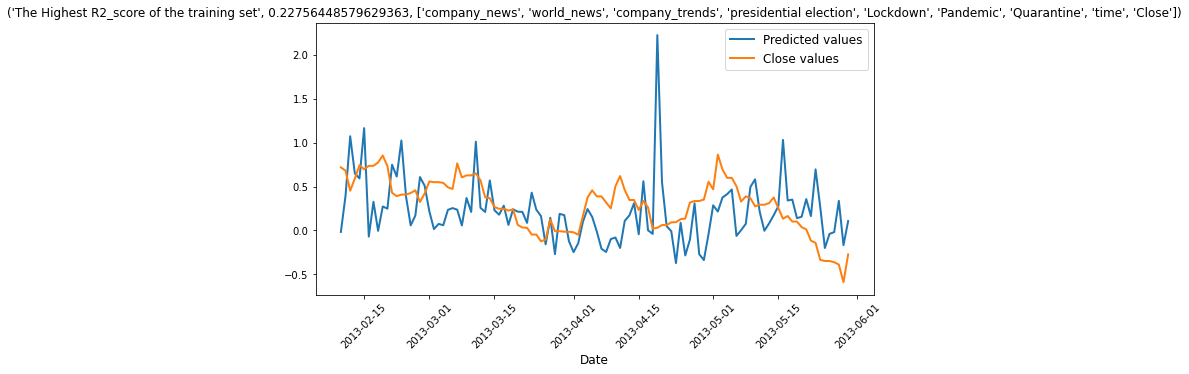

Root_mean_squared_error of the testing set:  0.43592699093010784
neg_mean_squared_error of the testing set:  -0.11415742547917358
mean_absolute_percentage_error of the testing set:  289.7360788045864
R2 score of the testing set:  -1.1161020228355523


In [40]:
for k,i in enumerate(selected_High_performence_features_names):

    df_1 = std_df[i[0][0]]
    X_train, X_test = df_1.drop('Close', axis=1)[:cutIdx], df_1.drop('Close', axis=1)[cutIdx:]
    y_train, y_test = df_1['Close'][:cutIdx], df_1['Close'][cutIdx:]

    # pandas dataframe to numpy array
    X_train = X_train.to_numpy()
    X_test = X_test.to_numpy()

    y_train = y_train.to_numpy()
    y_test = y_test.to_numpy()

    # adding Bias
    X_train = np.hstack([np.ones([X_train.shape[0],1]), X_train])
    X_test = np.hstack([np.ones([X_test.shape[0],1]), X_test])


    theta = getThetaClosedForm(X_train,y_train)

    Y_hat = predict(theta, X_test)
    
    plt.figure(figsize=(10, 5))
    plt.plot(std_df[cutIdx:].index, Y_hat, label = 'Predicted values', linewidth=2)
    # plt.plot(std_df_1[['time']][cutIdx:].index, std_df_1[['Close']][cutIdx:], label = 'True vales', linewidth=2)
    plt.plot(std_df.index, std_df['Close'], label = 'Close values', linewidth=2)

    plt.legend(loc = 'best', fontsize = 12)
    plt.xlabel('Date', fontsize = 12)
    plt.title((i[-1],i[0][k+1],i[0][0]))
    plt.show()
    
    
    plt.figure(figsize=(10, 5))
    plt.plot(std_df[cutIdx:].index, Y_hat, label = 'Predicted values', linewidth=2)
    # plt.plot(std_df_1[['time']][cutIdx:].index, std_df_1[['Close']][cutIdx:], label = 'True vales', linewidth=2)
    plt.plot(std_df[cutIdx:].index, std_df['Close'][cutIdx:], label = 'Close values', linewidth=2)

    plt.legend(loc = 'best', fontsize = 12)
    plt.xlabel('Date', fontsize = 12)
    plt.title((i[-1],i[0][k+1],i[0][0]))
    plt.xticks(rotation=45)
    plt.show()
    
    # check perfromance score
    RMSE = sqrt(mean_squared_error(y_test, Y_hat))
    print("Root_mean_squared_error of the testing set: ",RMSE)

    scores_lr = cross_val_score(LinearRegression(), 
                                X_test, y_test, 
                                cv=TimeSeriesSplit(n_splits=10),
                                scoring="neg_mean_squared_error")
    NMSE = np.mean(scores_lr)
    print("neg_mean_squared_error of the testing set: ",NMSE)
    MAPE_score = MAPE(y_test,Y_hat)
    print("mean_absolute_percentage_error of the testing set: ", MAPE_score )
    R2_score = r2_score(y_test,Y_hat)
    print("R2 score of the testing set: ", R2_score)

# Election 2016

In [41]:
# removing covid_19, coronavirus features which have only 0s.
df = election_2016[['company_news', 'world_news', 'company_trends', 
       'presidential election', 'Lockdown', 'Pandemic', 'Quarantine','zika',
        'time', 'Close']]

In [42]:
df.index = pd.to_datetime(df.index)


In [43]:
#Standardize training
mean = np.mean(df, axis=0)
std = np.std(df, axis=0, ddof=1)
std_df = (df-mean)/std

In [44]:
cutIdx = int(len(std_df)*0.7)

In [45]:
X_train = std_df.drop('Close', axis=1)[:cutIdx]
y_train = std_df['Close'][:cutIdx]

# adding Bias
X_train = np.hstack([np.ones([X_train.shape[0],1]), X_train])

theta = getThetaClosedForm(X_train,y_train)
coefficient_df_scratch = pd.DataFrame(data = theta, index =["Bias_Constant",
                                                            'company_news', 'world_news', 'company_trends', 
       'presidential election', 'Lockdown', 'Pandemic', 'Quarantine','zika',
        'time'], columns = ["Coefficient"] )

# coefficient_df_scratch.sort_values(by=['Coefficient'], axis=0, ascending=False)

# coefficient_df_scratch.iloc[(coefficient_df_scratch['Coefficient'].abs()).argsort()]

print("Coefficients of the Election 2016 timewindow: ")
print(coefficient_df_scratch.iloc[(-coefficient_df_scratch['Coefficient'].abs()).argsort()])

Coefficients of the Election 2016 timewindow: 
                       Coefficient
time                      0.627088
Bias_Constant            -0.323565
zika                      0.192177
company_trends            0.150363
Quarantine               -0.081240
Lockdown                  0.055666
presidential election     0.042674
company_news             -0.031057
Pandemic                 -0.016127
world_news               -0.003313


In [46]:
lists = list(std_df.columns)

lists.remove('Close') 

len_lists = len(lists)

target = ['Close']


In [47]:
# getting all combinations of features
lists_features = []
for i in range(len_lists):
    combs = list(combinations(lists,(i+1)))
#     print(combs)
    for k in combs:
        tuple_to_lists = list(k)
        tuple_to_lists.append('Close')
#         print(tuple_to_lists)
        lists_features.append(tuple_to_lists)

In [48]:
# getting PERFORMANCE_Scores of trainning for all combinations of features

features_PERFORMANCE_Scores = []
for features in lists_features:
    df_1 = std_df[features]
    X_train, X_test = df_1.drop('Close', axis=1)[:cutIdx], df_1.drop('Close', axis=1)[cutIdx:]
    y_train, y_test = df_1['Close'][:cutIdx], df_1['Close'][cutIdx:]
    
    # pandas dataframe to numpy array
    X_train = X_train.to_numpy()
    X_test = X_test.to_numpy()

    y_train = y_train.to_numpy()
    y_test = y_test.to_numpy()
    
    # adding Bias
    X_train = np.hstack([np.ones([X_train.shape[0],1]), X_train])
    X_test = np.hstack([np.ones([X_test.shape[0],1]), X_test])
    

    theta = getThetaClosedForm(X_train,y_train)
    
    Y_hat = predict(theta, X_train)

    # check perfromance score
    RMSE = sqrt(mean_squared_error(y_train, Y_hat))
#     print("mean_squared_error: ",RMSE)

    scores_lr = cross_val_score(LinearRegression(), 
                                X_train, y_train, 
                                cv=TimeSeriesSplit(n_splits=10),
                                scoring="neg_mean_squared_error")
    NMSE = np.mean(scores_lr)
#     print("neg_mean_squared_error: ",NMSE)
    MAPE_score = MAPE(y_train,Y_hat)
#     print("mean_absolute_percentage_error: ", MAPE_score )
    R2_score = r2_score(y_train,Y_hat)
#     print("R2 score: ", R2_score)
    features_PERFORMANCE_Scores.append([features,RMSE,NMSE,MAPE_score,R2_score])

In [49]:
# getting High_performence_features
selected_High_performence_features = []

for i in range(4):
    if i==3:
        features_PERFORMANCE_Scores.sort(key=lambda x: x[i+1],reverse=True)
    else:
        features_PERFORMANCE_Scores.sort(key=lambda x: x[i+1])
        
    selected_High_performence_features.append(features_PERFORMANCE_Scores[0])

In [50]:
# Names = ['The Lowest root_mean_squared_error', 'The Lowest neg_mean_squared_error', 'The Lowest mean_absolute_percentage_error', 'The Highest R2_score']

selected_High_performence_features_names = []
for f,n in zip(selected_High_performence_features, Names):
    k = [f,n]
    selected_High_performence_features_names.append(k)

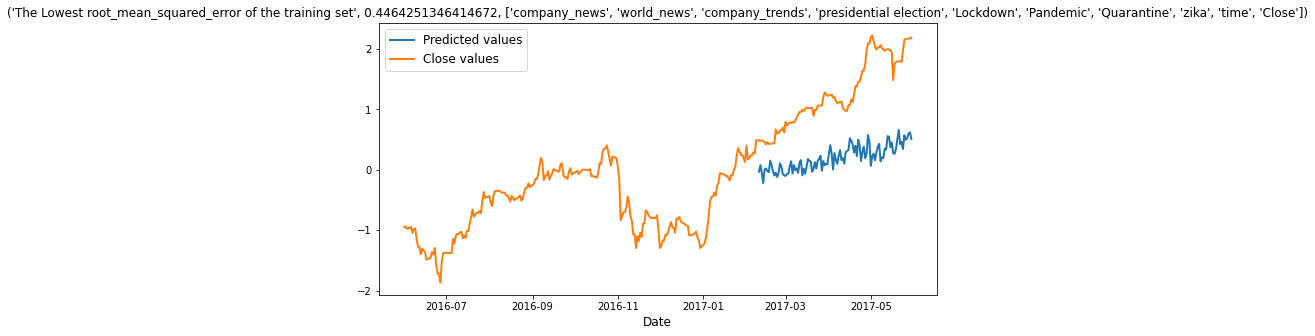

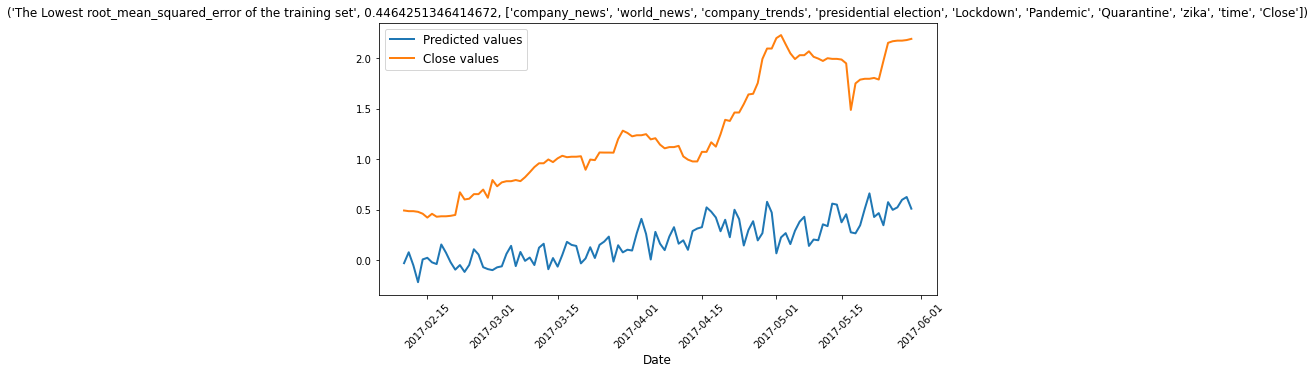

Root_mean_squared_error of the testing set:  1.1517698455987941
neg_mean_squared_error of the testing set:  -0.08396951102115337
mean_absolute_percentage_error of the testing set:  87.4619691349667
R2 score of the testing set:  -3.3177921891563216


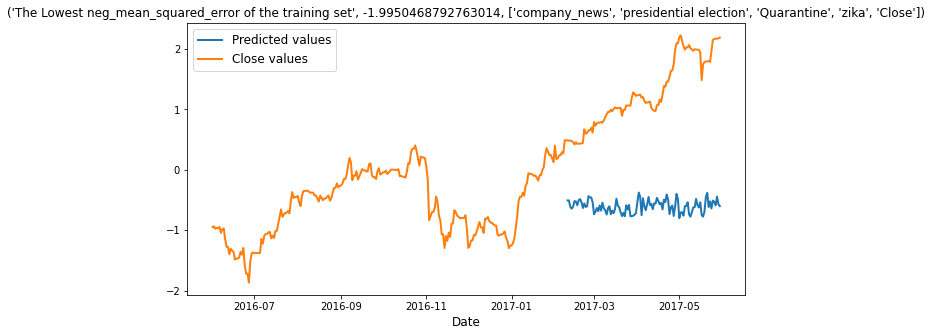

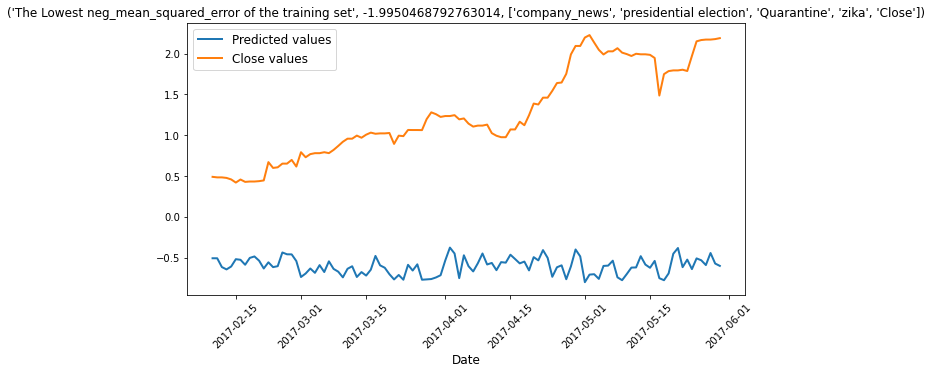

Root_mean_squared_error of the testing set:  1.9575480046396685
neg_mean_squared_error of the testing set:  -0.2671762608595023
mean_absolute_percentage_error of the testing set:  158.7941360107591
R2 score of the testing set:  -11.472547602319535


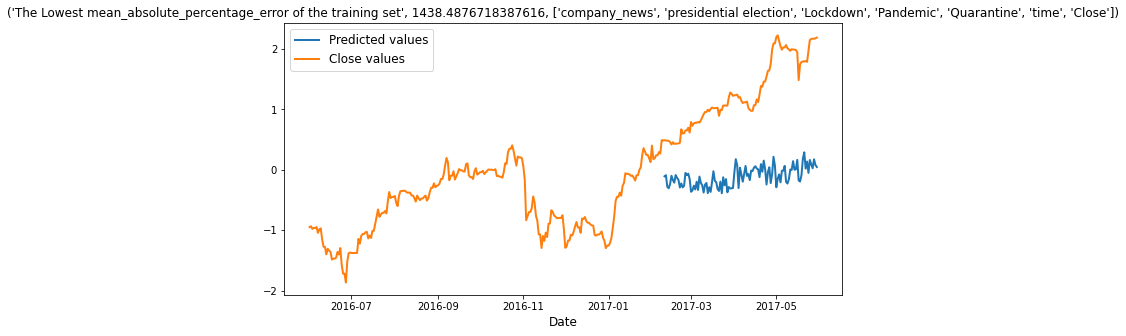

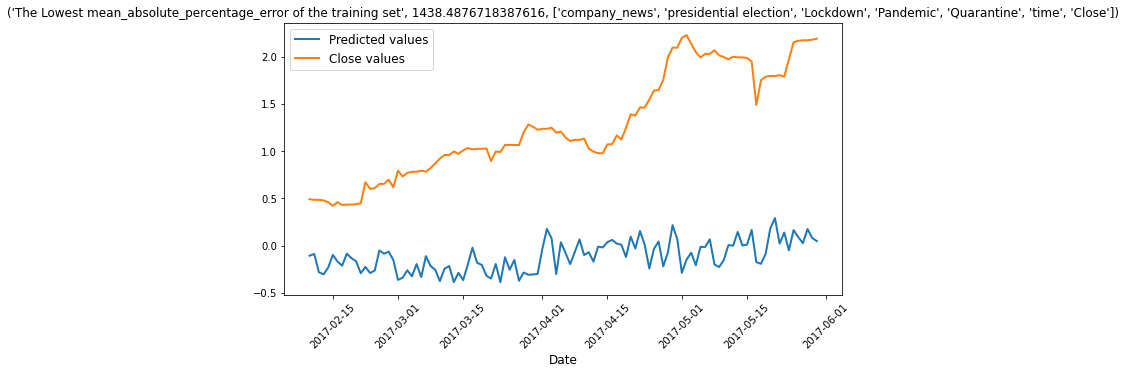

Root_mean_squared_error of the testing set:  1.469039667528488
neg_mean_squared_error of the testing set:  -0.07171243546049848
mean_absolute_percentage_error of the testing set:  114.54641748667976
R2 score of the testing set:  -6.024208171718465


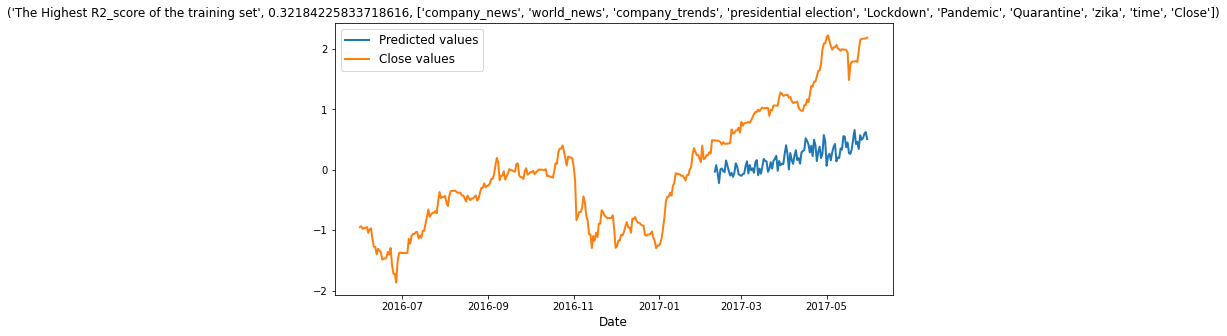

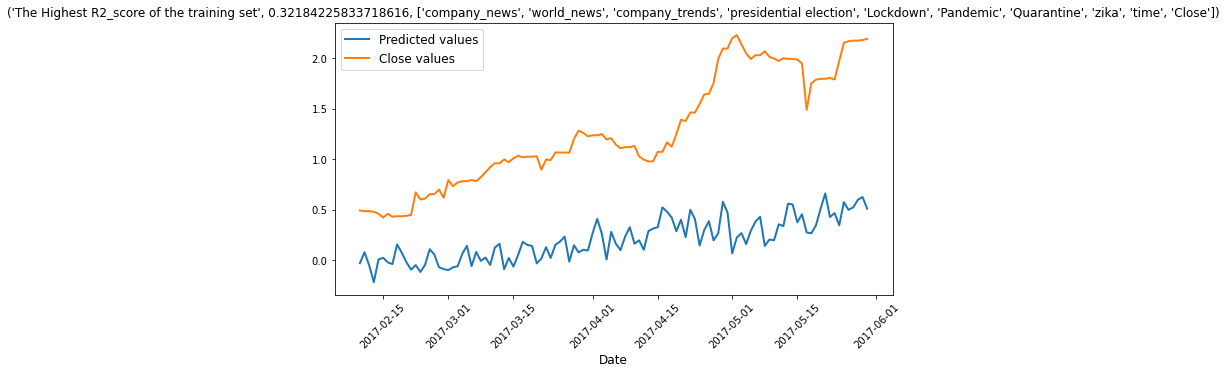

Root_mean_squared_error of the testing set:  1.1517698455987941
neg_mean_squared_error of the testing set:  -0.08396951102115337
mean_absolute_percentage_error of the testing set:  87.4619691349667
R2 score of the testing set:  -3.3177921891563216


In [51]:
for k,i in enumerate(selected_High_performence_features_names):

    df_1 = std_df[i[0][0]]
    X_train, X_test = df_1.drop('Close', axis=1)[:cutIdx], df_1.drop('Close', axis=1)[cutIdx:]
    y_train, y_test = df_1['Close'][:cutIdx], df_1['Close'][cutIdx:]

    # pandas dataframe to numpy array
    X_train = X_train.to_numpy()
    X_test = X_test.to_numpy()

    y_train = y_train.to_numpy()
    y_test = y_test.to_numpy()

    # adding Bias
    X_train = np.hstack([np.ones([X_train.shape[0],1]), X_train])
    X_test = np.hstack([np.ones([X_test.shape[0],1]), X_test])


    theta = getThetaClosedForm(X_train,y_train)

    Y_hat = predict(theta, X_test)
    
    plt.figure(figsize=(10, 5))
    plt.plot(std_df[cutIdx:].index, Y_hat, label = 'Predicted values', linewidth=2)
    # plt.plot(std_df_1[['time']][cutIdx:].index, std_df_1[['Close']][cutIdx:], label = 'True vales', linewidth=2)
    plt.plot(std_df.index, std_df['Close'], label = 'Close values', linewidth=2)

    plt.legend(loc = 'best', fontsize = 12)
    plt.xlabel('Date', fontsize = 12)
    plt.title((i[-1],i[0][k+1],i[0][0]))
    plt.show()
    
    
    plt.figure(figsize=(10, 5))
    plt.plot(std_df[cutIdx:].index, Y_hat, label = 'Predicted values', linewidth=2)
    # plt.plot(std_df_1[['time']][cutIdx:].index, std_df_1[['Close']][cutIdx:], label = 'True vales', linewidth=2)
    plt.plot(std_df[cutIdx:].index, std_df['Close'][cutIdx:], label = 'Close values', linewidth=2)

    plt.legend(loc = 'best', fontsize = 12)
    plt.xlabel('Date', fontsize = 12)
    plt.title((i[-1],i[0][k+1],i[0][0]))
    plt.xticks(rotation=45)
    plt.show()
    
    # check perfromance score
    RMSE = sqrt(mean_squared_error(y_test, Y_hat))
    print("Root_mean_squared_error of the testing set: ",RMSE)

    scores_lr = cross_val_score(LinearRegression(), 
                                X_test, y_test, 
                                cv=TimeSeriesSplit(n_splits=10),
                                scoring="neg_mean_squared_error")
    NMSE = np.mean(scores_lr)
    print("neg_mean_squared_error of the testing set: ",NMSE)
    MAPE_score = MAPE(y_test,Y_hat)
    print("mean_absolute_percentage_error of the testing set: ", MAPE_score )
    R2_score = r2_score(y_test,Y_hat)
    print("R2 score of the testing set: ", R2_score)

# 10 years

In [52]:
# removing covid_19, coronavirus features which have only 0s.
df = Company


In [53]:
df.index = pd.to_datetime(df.index)


In [54]:
#Standardize training
mean = np.mean(df, axis=0)
std = np.std(df, axis=0, ddof=1)
std_df = (df-mean)/std

In [55]:
cutIdx = int(len(std_df)*0.7)

In [56]:
X_train = std_df.drop('Close', axis=1)[:cutIdx]
y_train = std_df['Close'][:cutIdx]

# adding Bias
X_train = np.hstack([np.ones([X_train.shape[0],1]), X_train])

theta = getThetaClosedForm(X_train,y_train)
coefficient_df_scratch = pd.DataFrame(data = theta, index =["Bias_Constant",
                                                            'company_news', 'world_news', 'company_trends', 'Coronavirus',
       'presidential election', 'Lockdown', 'Pandemic', 'Quarantine', 'zika',
       'Covid-19', 'time'], columns = ["Coefficient"] )

# coefficient_df_scratch.sort_values(by=['Coefficient'], axis=0, ascending=False)

# coefficient_df_scratch.iloc[(coefficient_df_scratch['Coefficient'].abs()).argsort()]

print("Coefficients of the 10 years timewindow: ")
print(coefficient_df_scratch.iloc[(-coefficient_df_scratch['Coefficient'].abs()).argsort()])

Coefficients of the 10 years timewindow: 
                       Coefficient
time                      1.054779
Covid-19                 -0.496180
Pandemic                  0.482105
Coronavirus              -0.437803
Quarantine               -0.426009
Lockdown                 -0.131813
company_trends           -0.072228
presidential election    -0.007389
zika                     -0.004953
world_news                0.004274
company_news             -0.000534
Bias_Constant             0.000196


In [57]:
lists = list(std_df.columns)

lists.remove('Close') 

len_lists = len(lists)

target = ['Close']


In [58]:
# getting all combinations of features
lists_features = []
for i in range(len_lists):
    combs = list(combinations(lists,(i+1)))
#     print(combs)
    for k in combs:
        tuple_to_lists = list(k)
        tuple_to_lists.append('Close')
#         print(tuple_to_lists)
        lists_features.append(tuple_to_lists)

In [59]:
# getting PERFORMANCE_Scores of trainning for all combinations of features

features_PERFORMANCE_Scores = []
for features in lists_features:
    df_1 = std_df[features]
    X_train, X_test = df_1.drop('Close', axis=1)[:cutIdx], df_1.drop('Close', axis=1)[cutIdx:]
    y_train, y_test = df_1['Close'][:cutIdx], df_1['Close'][cutIdx:]
    
    # pandas dataframe to numpy array
    X_train = X_train.to_numpy()
    X_test = X_test.to_numpy()

    y_train = y_train.to_numpy()
    y_test = y_test.to_numpy()
    
    # adding Bias
    X_train = np.hstack([np.ones([X_train.shape[0],1]), X_train])
    X_test = np.hstack([np.ones([X_test.shape[0],1]), X_test])
    

    theta = getThetaClosedForm(X_train,y_train)
    
    Y_hat = predict(theta, X_train)

    # check perfromance score
    RMSE = sqrt(mean_squared_error(y_train, Y_hat))
#     print("mean_squared_error: ",RMSE)

    scores_lr = cross_val_score(LinearRegression(), 
                                X_train, y_train, 
                                cv=TimeSeriesSplit(n_splits=10),
                                scoring="neg_mean_squared_error")
    NMSE = np.mean(scores_lr)
#     print("neg_mean_squared_error: ",NMSE)
    MAPE_score = MAPE(y_train,Y_hat)
#     print("mean_absolute_percentage_error: ", MAPE_score )
    R2_score = r2_score(y_train,Y_hat)
#     print("R2 score: ", R2_score)
    features_PERFORMANCE_Scores.append([features,RMSE,NMSE,MAPE_score,R2_score])

In [60]:
# getting High_performence_features
selected_High_performence_features = []

for i in range(4):
    if i==3:
        features_PERFORMANCE_Scores.sort(key=lambda x: x[i+1],reverse=True)
    else:
        features_PERFORMANCE_Scores.sort(key=lambda x: x[i+1])
        
    selected_High_performence_features.append(features_PERFORMANCE_Scores[0])

In [61]:
# Names = ['The Lowest root_mean_squared_error', 'The Lowest neg_mean_squared_error', 'The Lowest mean_absolute_percentage_error', 'The Highest R2_score']

selected_High_performence_features_names = []
for f,n in zip(selected_High_performence_features, Names):
    k = [f,n]
    selected_High_performence_features_names.append(k)

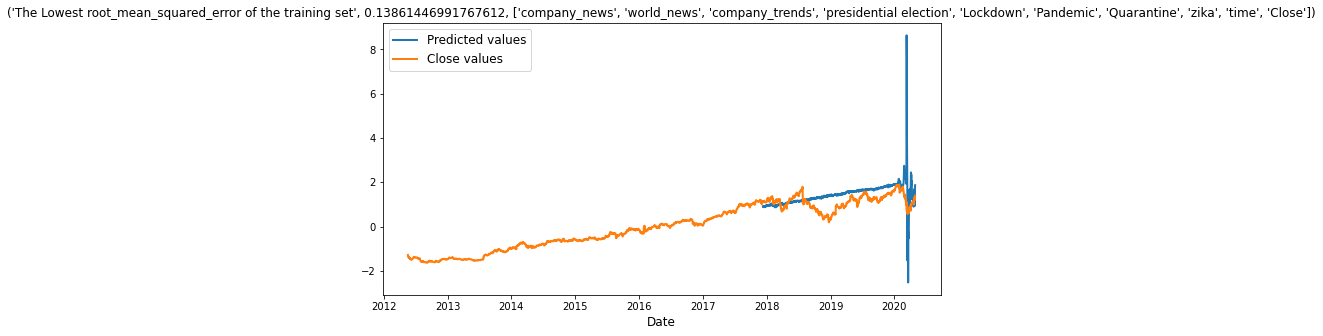

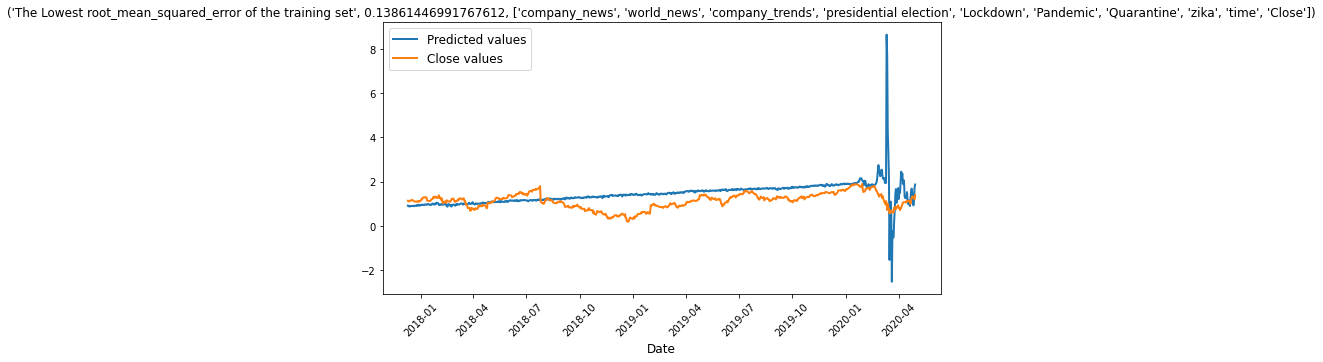

Root_mean_squared_error of the testing set:  0.6324690163207338
neg_mean_squared_error of the testing set:  -5.579043497648336
mean_absolute_percentage_error of the testing set:  55.04853638414375
R2 score of the testing set:  -2.3196056240991485


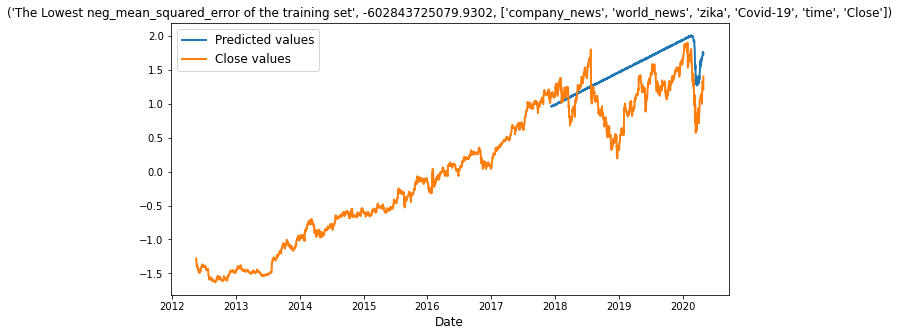

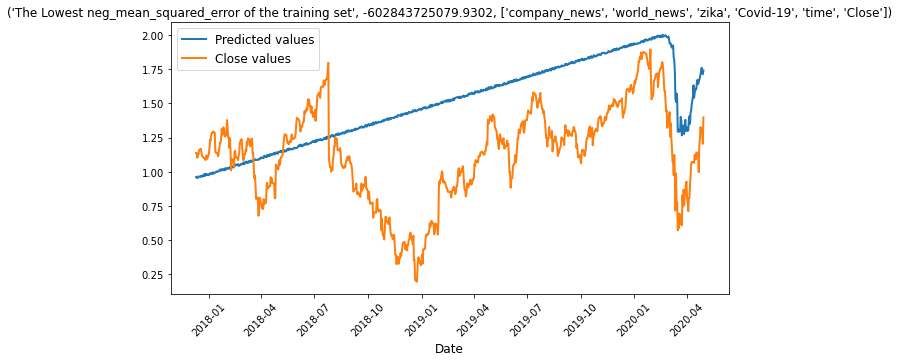

Root_mean_squared_error of the testing set:  0.5095576901347623
neg_mean_squared_error of the testing set:  -0.22645772891923502
mean_absolute_percentage_error of the testing set:  55.112521031524665
R2 score of the testing set:  -1.1547391488265086


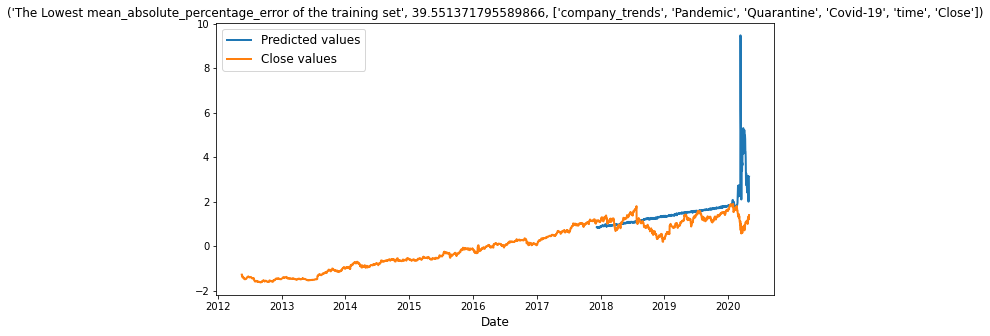

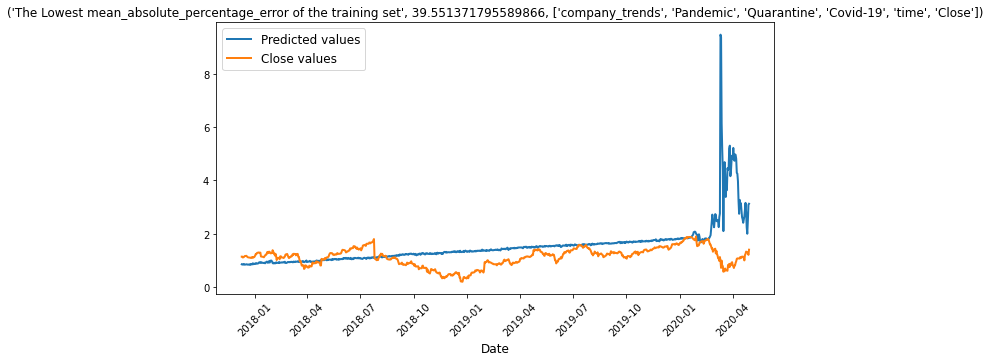

Root_mean_squared_error of the testing set:  0.9467177276639374
neg_mean_squared_error of the testing set:  -6.624061428279271
mean_absolute_percentage_error of the testing set:  65.81407271605741
R2 score of the testing set:  -6.437877148787701


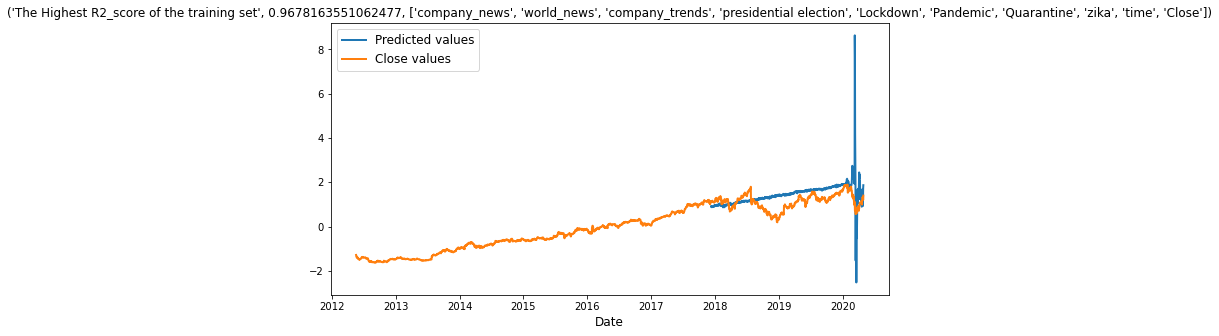

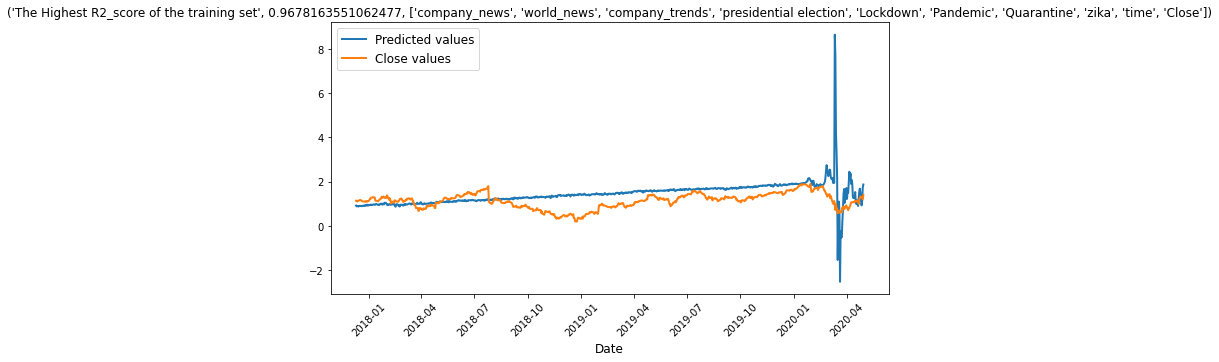

Root_mean_squared_error of the testing set:  0.6324690163207338
neg_mean_squared_error of the testing set:  -5.579043497648336
mean_absolute_percentage_error of the testing set:  55.04853638414375
R2 score of the testing set:  -2.3196056240991485


In [62]:
for k,i in enumerate(selected_High_performence_features_names):

    df_1 = std_df[i[0][0]]
    X_train, X_test = df_1.drop('Close', axis=1)[:cutIdx], df_1.drop('Close', axis=1)[cutIdx:]
    y_train, y_test = df_1['Close'][:cutIdx], df_1['Close'][cutIdx:]

    # pandas dataframe to numpy array
    X_train = X_train.to_numpy()
    X_test = X_test.to_numpy()

    y_train = y_train.to_numpy()
    y_test = y_test.to_numpy()

    # adding Bias
    X_train = np.hstack([np.ones([X_train.shape[0],1]), X_train])
    X_test = np.hstack([np.ones([X_test.shape[0],1]), X_test])


    theta = getThetaClosedForm(X_train,y_train)

    Y_hat = predict(theta, X_test)
    
    plt.figure(figsize=(10, 5))
    plt.plot(std_df[cutIdx:].index, Y_hat, label = 'Predicted values', linewidth=2)
    # plt.plot(std_df_1[['time']][cutIdx:].index, std_df_1[['Close']][cutIdx:], label = 'True vales', linewidth=2)
    plt.plot(std_df.index, std_df['Close'], label = 'Close values', linewidth=2)

    plt.legend(loc = 'best', fontsize = 12)
    plt.xlabel('Date', fontsize = 12)
    plt.title((i[-1],i[0][k+1],i[0][0]))
    plt.show()
    
    
    plt.figure(figsize=(10, 5))
    plt.plot(std_df[cutIdx:].index, Y_hat, label = 'Predicted values', linewidth=2)
    # plt.plot(std_df_1[['time']][cutIdx:].index, std_df_1[['Close']][cutIdx:], label = 'True vales', linewidth=2)
    plt.plot(std_df[cutIdx:].index, std_df['Close'][cutIdx:], label = 'Close values', linewidth=2)

    plt.legend(loc = 'best', fontsize = 12)
    plt.xlabel('Date', fontsize = 12)
    plt.title((i[-1],i[0][k+1],i[0][0]))
    plt.xticks(rotation=45)
    plt.show()
    
    # check perfromance score
    RMSE = sqrt(mean_squared_error(y_test, Y_hat))
    print("Root_mean_squared_error of the testing set: ",RMSE)

    scores_lr = cross_val_score(LinearRegression(), 
                                X_test, y_test, 
                                cv=TimeSeriesSplit(n_splits=10),
                                scoring="neg_mean_squared_error")
    NMSE = np.mean(scores_lr)
    print("neg_mean_squared_error of the testing set: ",NMSE)
    MAPE_score = MAPE(y_test,Y_hat)
    print("mean_absolute_percentage_error of the testing set: ", MAPE_score )
    R2_score = r2_score(y_test,Y_hat)
    print("R2 score of the testing set: ", R2_score)